# SC1015 DSAI Mini Project
---
The first thing we did for the project was cleaning and preparation of the dataset to help us gain meaningful insights from the dataset and help us answer the question we posed.

**Question:** How can we use volume and USA interest rate to predict bitcoin prices?

**Datasets:** 

Raw
- /datasets/data_btc.csv (https://huggingface.co/datasets/gauss314/bitcoin_daily)
- /raw/new_inflation_rate_cpi.xlsx (WAIT FOR BRANDON)


After Cleaning
- /datasets/data_btc.csv (https://huggingface.co/datasets/gauss314/bitcoin_daily)
- /datasets/expanded2_usa_inflation_rate.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

In [2]:
# Load the data
inflation_data_path = 'datasets/expanded2_usa_inflation_rate.csv'
bitcoin_data_path = 'datasets/data_btc.csv'

inflation_data = pd.read_csv(inflation_data_path)
bitcoin_data = pd.read_csv(bitcoin_data_path)

In [3]:
inflation_data

,date,Monthly Inflation Rate,Annual Inflation Rate
0,01/02/2024,0.4,3.2
1,02/02/2024,0.4,3.2
2,03/02/2024,0.4,3.2
3,04/02/2024,0.4,3.2
4,05/02/2024,0.4,3.2
...,...,...,...
3707,27/01/2014,0.2,1.6
3708,28/01/2014,0.2,1.6
3709,29/01/2014,0.2,1.6
3710,30/01/2014,0.2,1.6


In [4]:
inflation_data.shape

(3712, 3)

In [5]:
inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3712 entries, 0 to 3711
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3712 non-null   object 
 1   Monthly Inflation Rate  3712 non-null   float64
 2   Annual Inflation Rate   3712 non-null   float64
dtypes: float64(2), object(1)
memory usage: 87.1+ KB


In [6]:
bitcoin_data

,date,price,market_caps,total_volumes
0,28/4/2013,135.300000,1.500518e+09,0.000000e+00
1,29/4/2013,141.960000,1.575032e+09,0.000000e+00
2,30/4/2013,135.300000,1.501657e+09,0.000000e+00
3,1/5/2013,117.000000,1.298952e+09,0.000000e+00
4,2/5/2013,103.430000,1.148668e+09,0.000000e+00
...,...,...,...,...
3640,16/4/2023,30312.161880,5.869698e+11,1.102826e+10
3641,17/4/2023,30304.807515,5.862682e+11,1.118804e+10
3642,18/4/2023,29467.459829,5.699581e+11,1.677182e+10
3643,19/4/2023,30365.904168,5.877302e+11,1.807854e+10


In [7]:
bitcoin_data.shape

(3645, 4)

In [8]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3645 entries, 0 to 3644
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3645 non-null   object 
 1   price          3643 non-null   float64
 2   market_caps    3642 non-null   float64
 3   total_volumes  3643 non-null   float64
dtypes: float64(3), object(1)
memory usage: 114.0+ KB


# Preprocessing



Various preprocessing steps and data analysis tasks were done using the pandas library. 

The first stage of preprocessing was done in Excel Spreadsheet.

Step 1: We converted the date format from mm/dd/yyyy in **'raw/new_inflation_rate_cpi.xlsx'** to dd/mm/yyyy in **'/datasets/expanded2_usa_inflation_rate.csv'**. 

Step 2: As the raw dataset only includes one data point per month. For a larger range of predictions, we expanded the number of data points by extrapolating each data point per month across each respective month.

1. **Preprocessing with `pd.to_datetime`:** The `pd.to_datetime` function converts the 'date' column in both `inflation_data` and `bitcoin_data` DataFrames to datetime objects. The parameter `dayfirst=True` specifies that the date format starts with the day, followed by the month and year.

2. **Merging DataFrames:** The code merges the `bitcoin_data` and `inflation_data` DataFrames on the 'date' column using the `pd.merge` function, performing an inner join to retain only the rows with matching dates.

3. **Handling NaN values:** Any missing values in the DataFrame (`merged_data`) are filled with the mean of their respective columns using the `fillna` method. This step is done here

In [9]:
# Preprocessing
inflation_data['date'] = pd.to_datetime(inflation_data['date'], dayfirst=True)
bitcoin_data['date'] = pd.to_datetime(bitcoin_data['date'], dayfirst=True)

# Merging the data on the 'date' column
merged_data = pd.merge(bitcoin_data, inflation_data, on='date', how='inner')

# Handling NaN values by filling them with the mean of their respective columns
merged_data_filled = merged_data.fillna(merged_data.mean(numeric_only=True))

# Exploratory Data Analysis

**Plotting Correlation Matrix Heatmap:** Finally, a correlation matrix heatmap is plotted using seaborn (`sns`) and matplotlib (`plt`). This heatmap visualizes the correlation between different numerical variables in the dataset. The correlation coefficients are displayed as annotations on the heatmap.

**Statistical Overview:** Statistical overview such as mean, median and mode of each variable.

**Plotting Statistical Overview:** Boxplot, histogram and violin plots of each variable.

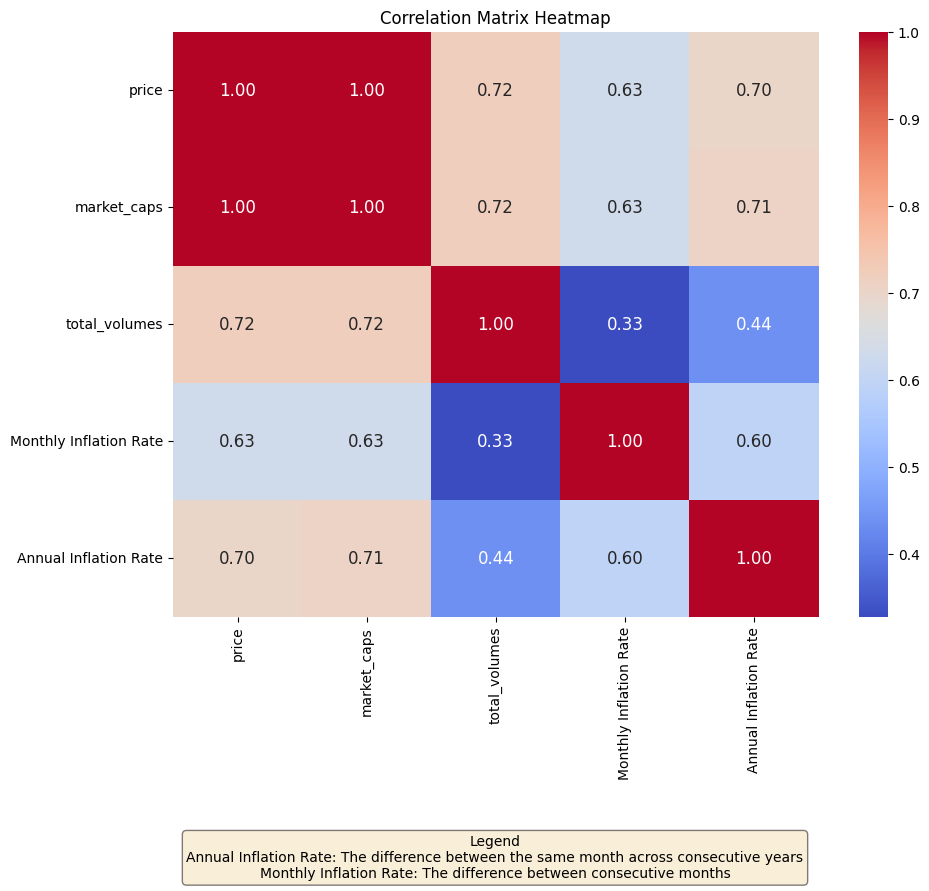

In [26]:
plt.figure(figsize=(10, 8))  # Adjust figure size for a good layout
# Plotting the correlation matrix heatmap
correlation_matrix = merged_data.corr()
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Matrix Heatmap')
# Define the legend text
legend_text = """Legend
Annual Inflation Rate: The difference between the same month across consecutive years
Monthly Inflation Rate: The difference between consecutive months"""
# Add the legend below the heatmap, lowered further to avoid overlapping
plt.gca().figure.text(0.5, -0.05, legend_text, ha='center', va='top', fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

In [20]:
merged_data_filled.describe()

,price,market_caps,total_volumes,Monthly Inflation Rate,Annual Inflation Rate
count,3397.000000,3.397000e+03,3.397000e+03,3397.000000,3397.000000
mean,12292.786598,2.278836e+11,1.518468e+10,0.228407,2.694878
std,15800.010891,2.990700e+11,1.890148e+10,0.293525,2.384413
min,172.147900,2.362640e+09,2.642092e+06,-0.800000,-0.200000
25%,610.683800,8.960483e+09,4.013093e+08,0.100000,1.300000
50%,6627.162515,1.144639e+11,4.358427e+09,0.200000,1.900000
75%,17039.873910,3.240726e+11,2.582870e+10,0.400000,2.700000
max,67617.015540,1.278798e+12,1.788941e+11,1.200000,9.100000


In [24]:
merged_data_filled.head

<bound method NDFrame.head of            date         price   market_caps  total_volumes  \
0    2014-01-01    767.740000  9.358693e+09   2.344860e+07   
1    2014-01-02    772.530000  9.417083e+09   1.683780e+07   
2    2014-01-03    825.470000  1.006242e+10   5.417150e+07   
3    2014-01-04    849.140000  1.035095e+10   3.634470e+07   
4    2014-01-05    919.410000  1.120754e+10   6.241460e+07   
...         ...           ...           ...            ...   
3392 2023-04-16  30312.161880  5.869698e+11   1.102826e+10   
3393 2023-04-17  30304.807515  5.862682e+11   1.118804e+10   
3394 2023-04-18  29467.459829  5.699581e+11   1.677182e+10   
3395 2023-04-19  30365.904168  5.877302e+11   1.807854e+10   
3396 2023-04-20  28389.469674  5.504610e+11   2.225937e+10   

      Monthly Inflation Rate  Annual Inflation Rate  
0                        0.2                    1.6  
1                        0.2                    1.6  
2                        0.2                    1.6  
3        

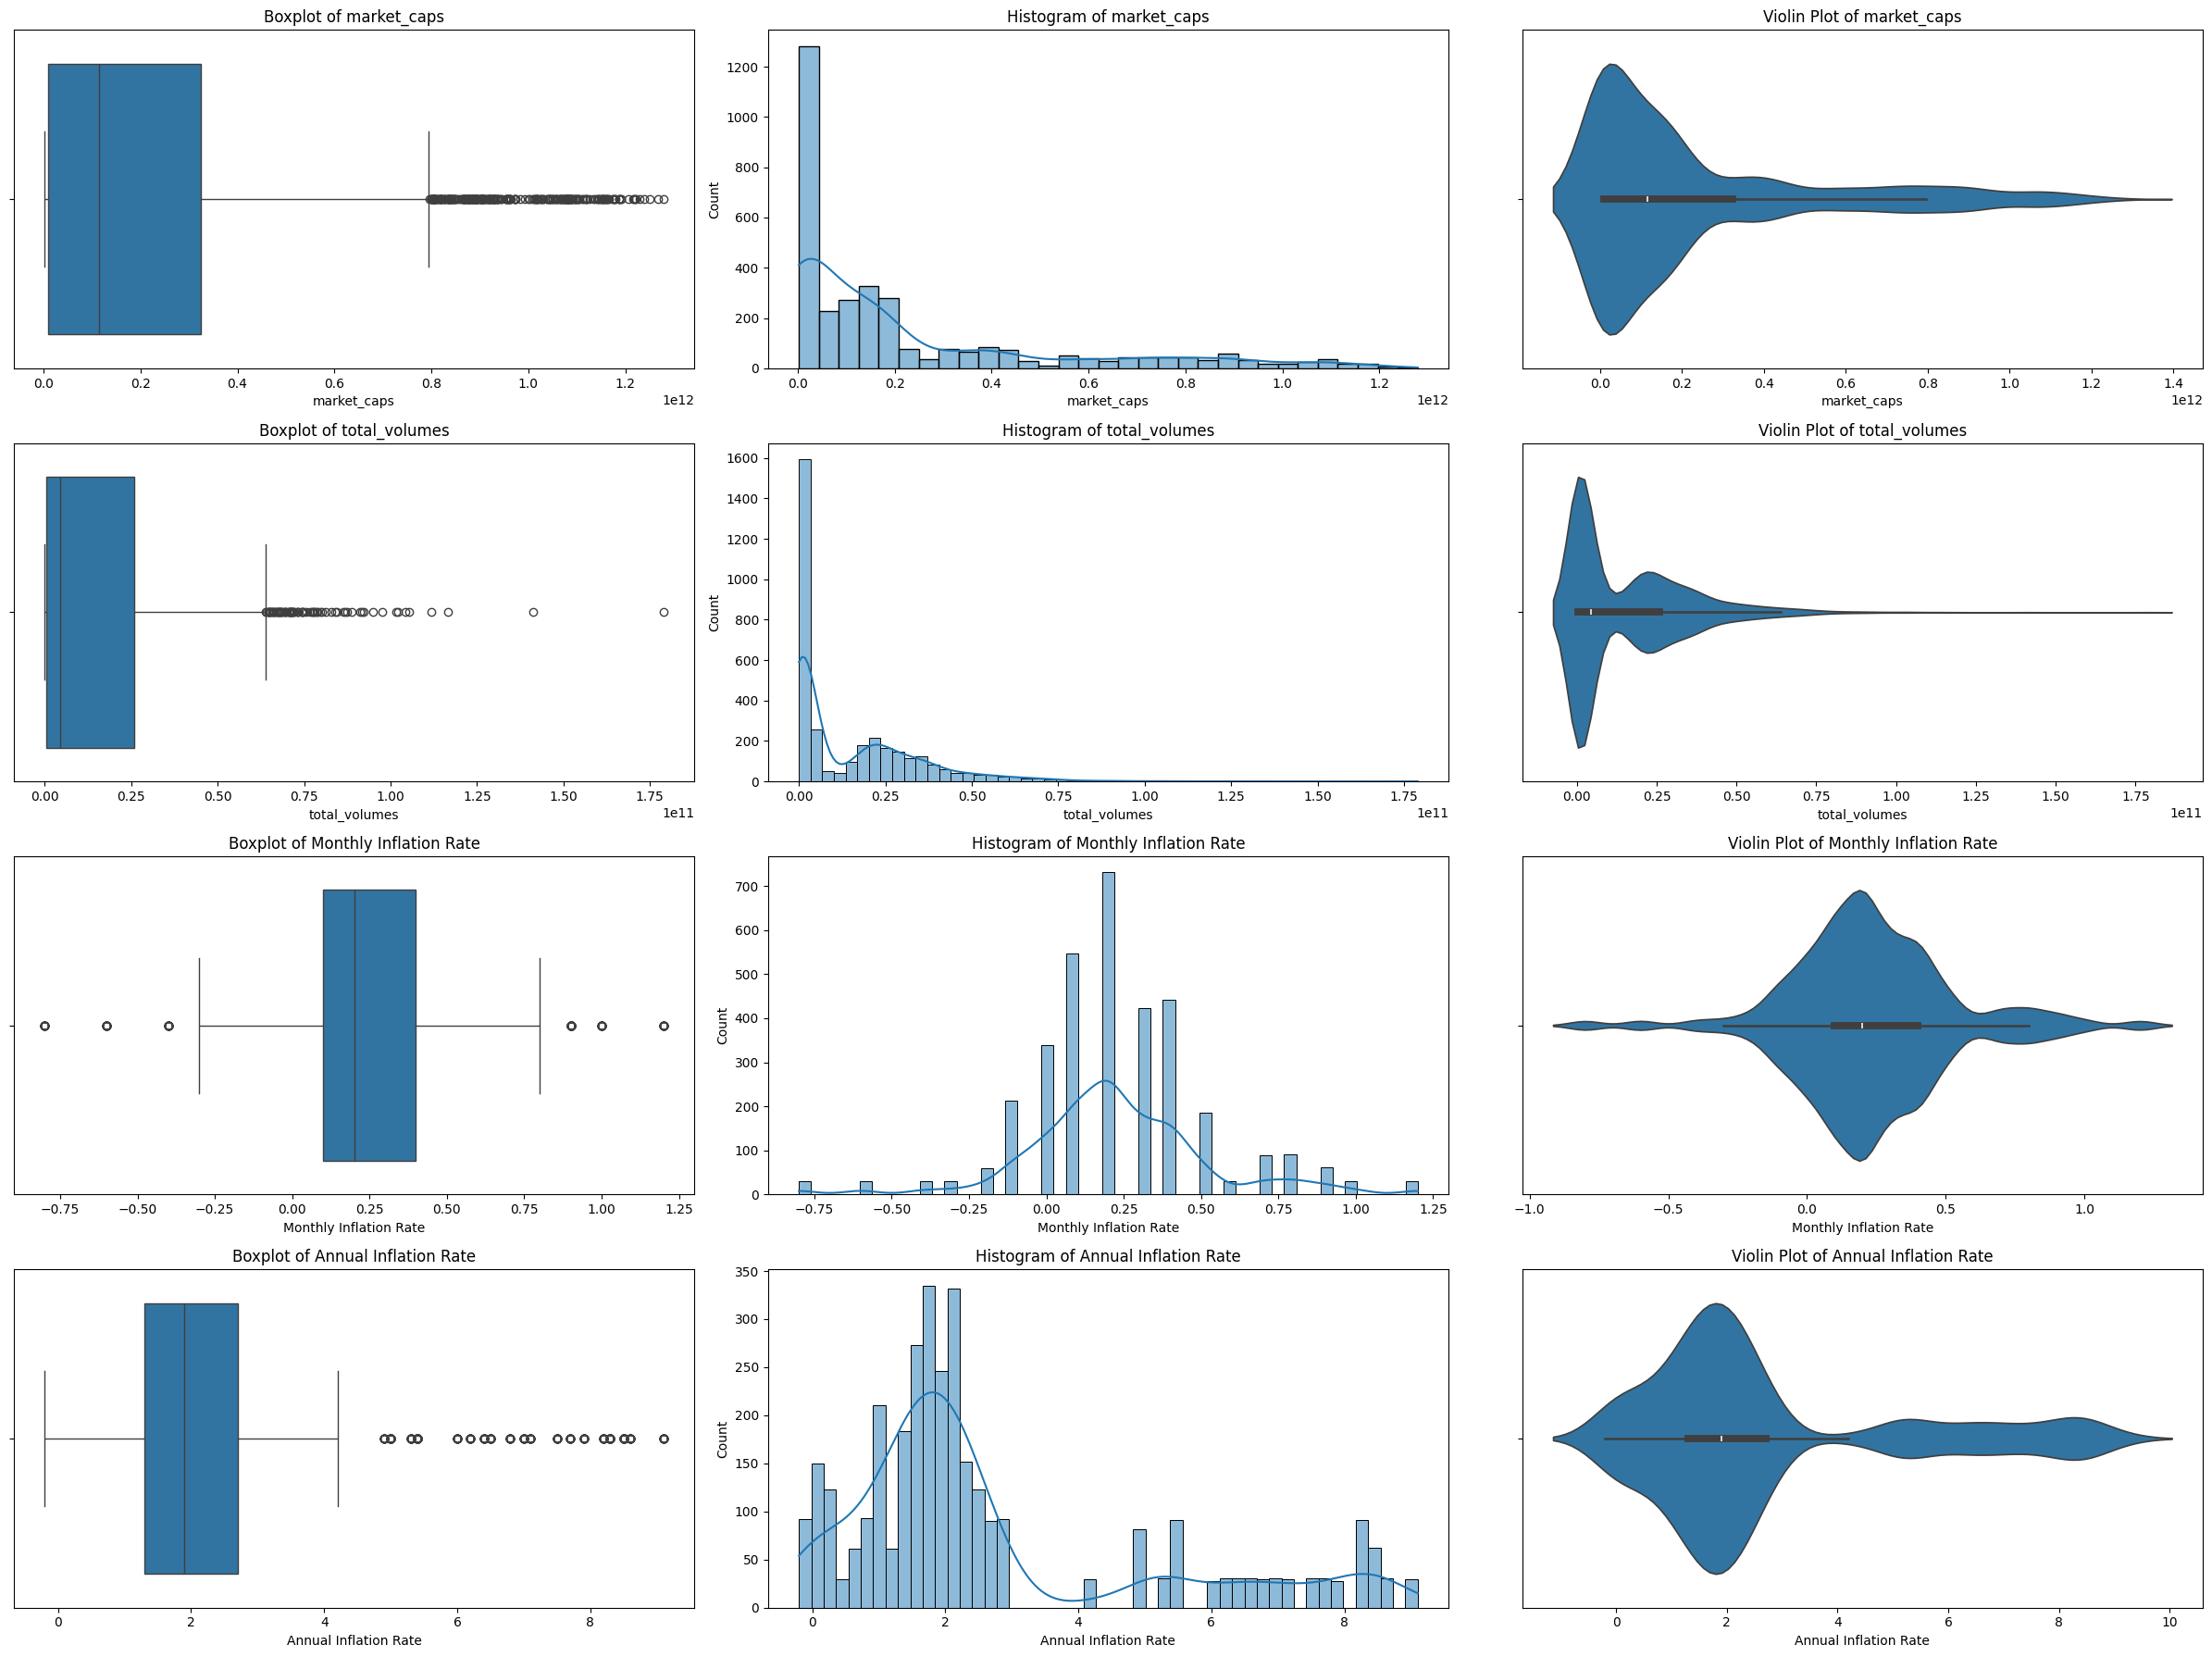

In [21]:
# Show relation between each top predictors against diagnosis
f, axes = plt.subplots(4, 3, figsize=(24, 18))

count = 0
for var in merged_data.columns[1:]:  # Exclude 'Price' column
    if (var == 'price'): continue

    # Boxplot comparing the numerical variable against the boolean variable 'diagnosis'
    sns.boxplot(data=merged_data_filled, x=var, ax=axes[count, 0])
    axes[count, 0].set_title(f'Boxplot of {var}')

    # Histogram of the numerical variable separated by the boolean variable 'diagnosis'
    sns.histplot(data=merged_data_filled, x=var, ax=axes[count, 1], kde=True)
    axes[count, 1].set_title(f'Histogram of {var}')

    # Violin plot comparing the numerical variable against the boolean variable 'diagnosis'
    sns.violinplot(data=merged_data_filled, x=var, ax=axes[count, 2])
    axes[count, 2].set_title(f'Violin Plot of {var}')

    count += 1

plt.tight_layout()
plt.show()


##### Based on the correlation matrix heatmap, we can observe that price and market_caps are directly proportional based on the correlation index which is 1 because market_caps is directly derived from price. Therefore, we decided not to use market_caps as an predictor. Moving on, the variables 'total_volumes' and 'Monthly Extrapolated Inflation Rate' have a correlation of 0.7 and higher. Thus, we decided to pick both of them as predictors. 
---

1. **Defining Features and Target Variable:** Features (`X`) and the target variable (`y`) are defined for training a machine learning model. In this case, 'Monthly Extrapolated Inflation Rate' and 'total_volumes' are chosen as features, while 'price' is the target variable. In other words, we removed the variables ''Monthly Extrapolated Difference in Inflation Rate' and 'market_caps' because we deemed them irrelelvant in our exploration.

2. **K-Fold Cross-Validation:** A K-Fold cross-validation setup with 5 splits (`n_splits=5`) is created using the `KFold` class from scikit-learn. This ensures robustness of the model evaluation. A Linear Regression model is instantiated (`model = LinearRegression()`).

3. **Cross-Validation Predictions:** Cross-validation is performed using the `cross_val_predict` function, which generates predictions for each fold of the K-Fold validation.

4. **Converting Dates:** Dates in the DataFrame are converted to datetime objects using `pd.to_datetime`. This conversion ensures that dates are treated as datetime data types for subsequent operations.


In [13]:
# Extracting the variables that we will be using 
merged_data_final_filled = merged_data_filled[['date', 'price', 'total_volumes', 'Annual Inflation Rate']]

# Features and target variable
X = merged_data_final_filled[['Annual Inflation Rate', 'total_volumes']]
y = merged_data_final_filled['price']

# K-Fold setup
kf = KFold(n_splits=5, random_state=32, shuffle=True)
model = LinearRegression()

# Perform cross-validation and store predictions for each fold
predictions = cross_val_predict(model, X, y, cv=kf)

# Convert dates to datetime objects
dates = merged_data_final_filled['date']
dates = pd.to_datetime(dates)

# Performance Metrics Evaluation for K-Fold Linear Regression Model

This code performs k-fold cross-validation to evaluate the performance of a machine learning model using two metrics: 
1. R-squared (coefficient of determination) 
2. RMSE (root mean squared error).

Here's a breakdown of the code:

1. **Initialization:** Two empty lists, `r2_scores` and `rmse_scores`, are initialized to store the performance metrics for each fold.

2. **Cross-validation Loop:** The code iterates over each fold using `kf.split(X)` where `kf` is a `KFold` object initialized earlier with the desired number of splits (folds). For each fold:
   - The data is split into training and testing sets using the indices obtained from `kf.split(X)`.
   - The machine learning model (`model`) is trained on the training data (`X_train`, `y_train`) using the `fit` method.
   - Predictions are made on the test data (`X_test`) using the trained model (`model.predict`).
   - R-squared and RMSE are calculated between the actual target values (`y_test`) and the predicted values (`y_pred`).
   - The calculated R-squared and RMSE scores are appended to the respective lists (`r2_scores`, `rmse_scores`).

3. **Print Scores:** After evaluating the model on all folds, the code prints the R-squared and RMSE scores for each fold using a loop. Each fold's index, along with its corresponding R-squared and RMSE scores, is displayed.

4. **Calculate Average Scores:** Finally, the code calculates the average R-squared and RMSE scores across all folds using NumPy's `np.mean` function. These average scores provide a summary of the model's overall performance across multiple folds of the cross-validation process.

Overall, this code efficiently evaluates the performance of the machine learning model using k-fold cross-validation and provides insights into its consistency and generalization performance across different subsets of the data.

In [14]:
# Initialize lists to store performance metrics for each fold
r2_scores = []
rmse_scores = []

# Iterate over each fold
for train_index, test_index in kf.split(X):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate R-squared score
    r2 = r2_score(y_test, y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Append scores to the respective lists
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# Print the R-squared scores and RMSE for each fold
for i in range(len(r2_scores)):
    print(f"Fold {i+1}: R-squared = {r2_scores[i]:.4f}, RMSE = {rmse_scores[i]:.4f}")

# Calculate average R-squared score and RMSE across all folds
avg_r2 = np.mean(r2_scores)
avg_rmse = np.mean(rmse_scores)
print("\nAverage R-squared across all folds:", avg_r2)
print("Average RMSE across all folds:", avg_rmse)


Fold 1: R-squared = 0.6861, RMSE = 8720.2101
Fold 2: R-squared = 0.7194, RMSE = 8507.0833
Fold 3: R-squared = 0.7029, RMSE = 8799.2033
Fold 4: R-squared = 0.6951, RMSE = 8684.2676
Fold 5: R-squared = 0.7014, RMSE = 8453.8811

Average R-squared across all folds: 0.7009871746802483
Average RMSE across all folds: 8632.929089344407


##### The average R-squared value across all folds is approximately 0.6922, and the average RMSE value across all folds is approximately 8761.2009. These average scores provide a summary of the model's overall performance across all folds of the cross-validation process. An average R-squared value of 0.6922 indicates that, on average, the model explains around 69.22% of the variance in the target variable, which is considered fairly good. Similarly, an average RMSE value of approximately 8761.2009 indicates that, on average, the model's predictions are within approximately 8761.2009 dollars of the actual values.
---

# Data Visualization for K-Fold Linear Regression Model

Below code generates scatter plots to visualize the predictions made by the model for each fold in a cross-validation process, as well as the average predictions across all folds.

**Figure Setup:** 
The code starts by creating a new figure for the scatter plots. The figure size is set to (5, 20), which means it will have a width of 5 inches and a height of 20 inches.

**Scatter Plot for Each Fold:**
1. The code then iterates over each fold using enumerate(kf.split(X), 1), where kf is a KFold object. This allows it to loop over each fold while also keeping track of the fold number.
2. Inside the loop, for each fold, it creates a subplot with plt.subplot(6, 1, i), where 6 is the total number of folds and i is the current fold number. This sets up a grid of 6 rows and 1 column of subplots, with the current subplot being the i-th subplot.
3. It then splits the data into training and testing sets based on the current fold indices.
4. The model is trained on the training data (X_train and y_train).
5. Predictions are made on the testing data (X_test).
6. A scatter plot is created using plt.scatter to visualize the actual prices (y_test) against the predicted prices (fold_pred) for the current fold. Each point on the scatter plot represents a data point in the testing set.
7. The identity line (y = x) is plotted using plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--'). This line represents perfect predictions, where the actual price equals the predicted price.
8. Title, x-axis label, y-axis label, and legend are added to the subplot.

**Scatter Plot for Average Predictions:**
1. After plotting the scatter plots for each fold, the code creates one final subplot to visualize the average predictions across all folds.
2. Similar to the previous step, it creates a subplot using plt.subplot(6, 1, 6).
3. It then creates a scatter plot to visualize the actual prices (y) against the average predicted prices (predictions). Each point on the scatter plot represents a data point in the entire dataset.
4. The identity line (y = x) is plotted again to represent perfect predictions.
5. Title, x-axis label, y-axis label, and legend are added to the subplot.

**Displaying the Plot:**
Finally, plt.tight_layout() ensures that the subplots are properly spaced, and plt.show() displays the entire figure with all the subplots.

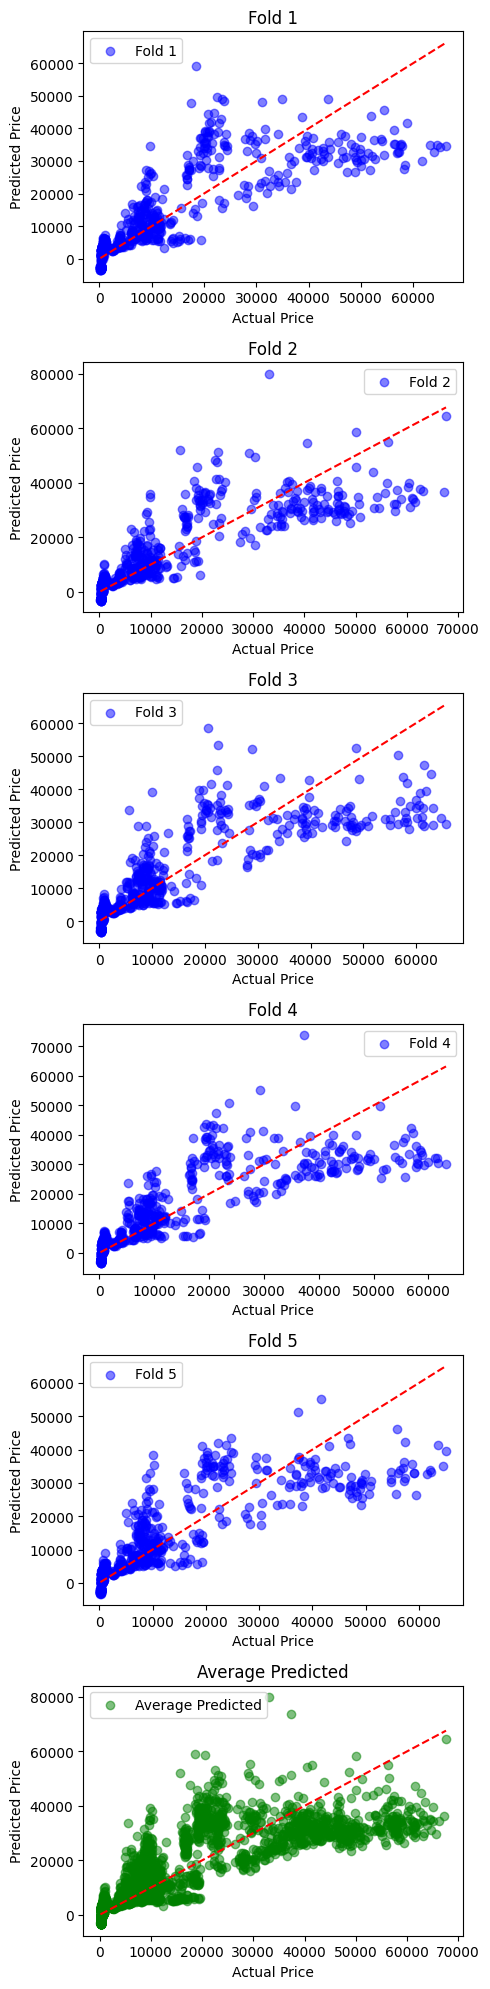

In [15]:
# Scatter plot for each fold's predictions
plt.figure(figsize=(5, 20))

for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    plt.subplot(6, 1, i)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    fold_pred = model.predict(X_test)
    plt.scatter(y_test, fold_pred, label=f'Fold {i}', color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Identity line
    plt.title(f'Fold {i}')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()

# Scatter plot for average predictions
plt.subplot(6, 1, 6)
plt.scatter(y, predictions, label='Average Predicted', color='green', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')  # Identity line
plt.title('Average Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()

plt.tight_layout()
plt.show()

#### Overall, this code provides a visual representation of how well the model's predictions align with the actual prices across different folds of the cross-validation process. It helps in assessing the model's performance and understanding its predictive capabilities.
---

This code generates line plots to visualize the predicted prices for each fold in a cross-validation process, as well as the average predicted prices across all folds. Here's a breakdown of what the code does:

    
**Figure Setup:** 
The code starts by creating a new figure for the line plots. The figure size is set to (10, 22), which means it will have a width of 10 inches and a height of 22 inches.

**Plotting Predicted Prices for Each Fold:**
1. The code then iterates over each fold using enumerate(kf.split(X), 1), where kf is a KFold object. This allows it to loop over each fold while also keeping track of the fold number.
2. Inside the loop, for each fold, it creates a subplot with plt.subplot(6, 1, i), where 6 is the total number of folds and i is the current fold number. This sets up a grid of 6 rows and 1 column of subplots, with the current subplot being the i-th subplot.
3. It then splits the data into training and testing sets based on the current fold indices.
4. The model is trained on the training data (X_train and y_train).
5. Predictions are made on the testing data (X_test).
6. A scatter plot is created to visualize the actual prices against the predicted prices for the current fold. Each point on the scatter plot represents a data point in the testing set. The actual prices are plotted as blue points (plt.scatter(dates[test_index], y.iloc[test_index], label='Actual', color='blue', alpha=0.7)), and the predicted prices are plotted as red dashed lines (plt.plot(dates[test_index], fold_pred, linestyle='--', color='red', label='Predicted')).
7. Title, x-axis label, y-axis label, and legend are added to the subplot.

**Plotting Average Predicted Values:**
1. After plotting the predicted prices for each fold, the code creates one final subplot to visualize the average predicted prices across all folds.
2. Similar to the previous step, it creates a subplot using plt.subplot(6, 1, 6).
3. It then creates a line plot to visualize the actual prices and the average predicted prices over time. The actual prices are plotted as blue lines (plt.plot(dates, y, label='Actual', color='blue')), and the average predicted prices are plotted as red dashed lines (plt.plot(dates, predictions, label='Average Predicted', color='red', linestyle='--')).
4. Title, x-axis label, y-axis label, and legend are added to the subplot.

**Displaying the Plot:**
Finally, plt.tight_layout() ensures that the subplots are properly spaced, and plt.show() displays the entire figure with all the subplots.


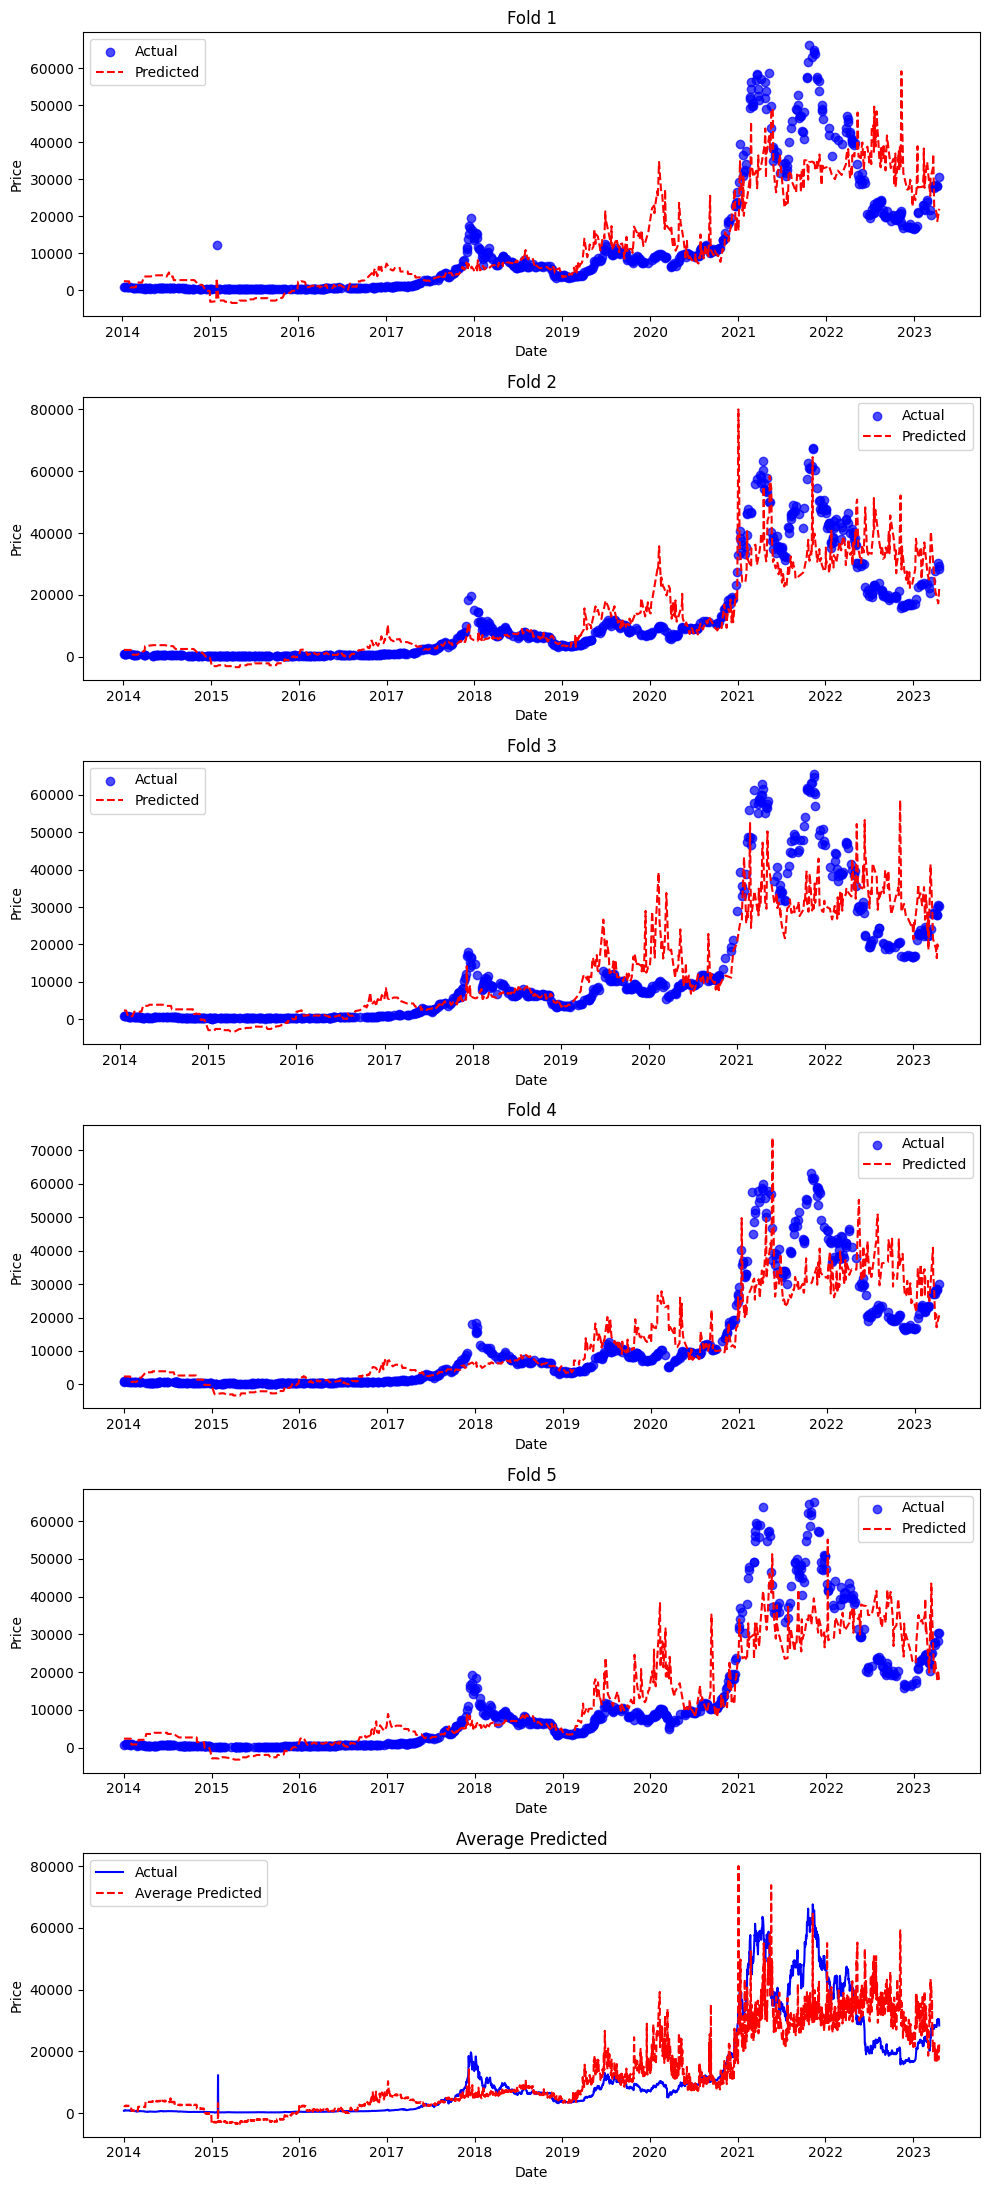

In [16]:
# Plotting predicted prices for each fold
plt.figure(figsize=(10, 22))

for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    plt.subplot(6, 1, i)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    fold_pred = model.predict(X_test)
    plt.scatter(dates[test_index], y.iloc[test_index], label='Actual', color='blue', alpha=0.7)
    plt.plot(dates[test_index], fold_pred, linestyle='--', color='red', label='Predicted')
    plt.title(f'Fold {i}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

# Plotting average predicted values
plt.subplot(6, 1, 6)
plt.plot(dates, y, label='Actual', color='blue')
plt.plot(dates, predictions, label='Average Predicted', color='red', linestyle='--')
plt.title('Average Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

#### Overall, the above code provides a visual representation of how well the model's predictions align with the actual prices over time for each fold in the cross-validation process. It helps in assessing the model's performance and understanding its predictive capabilities across different time periods.

# Additional implementations of models beyond the scope of the course

- **The Models:**
  - On top of linear regression, the additional models are Random Forest, Gradient Boosting, and XGBoost models (we included the linear regression model to aid in comparison)
- **K-Fold Cross-Validation Setup:**
  - K-fold was done across all 4 models to prevent overfitting
  - kf initializes a K-Fold cross-validator with 5 splits, shuffling enabled to randomize data points before splitting, and a random state set to 42 for reproducibility.
  - linear_model creates an instance of the LinearRegression class.
  - forest_model initializes a RandomForestRegressor with 100 trees, using 'sqrt' (square root of the number of features) as the max features per split, and a random state of 42.
  - gb_model creates a GradientBoostingRegressor with 100 boosting stages, and a random state of 42 to ensure consistent results across runs.
  - xgb_model initializes an XGBRegressor configured for regression with squared error loss and a random state of 42.
- **Model Training and Prediction Using Cross-Validation:**
  - predictions_linear is an array of predicted 'price' values using Linear Regression, obtained by cross-validation over X, y, and kf.
  - predictions_forest, predictions_gb, and predictions_xgb are similar arrays obtained for Random Forest, Gradient Boosting, and XGBoost models respectively.
- **Model Evaluation:**
  - linear_cv_r2 computes the R² (coefficient of determination) regression score for the Linear Regression model predictions.
  - linear_cv_rmse calculates the root mean squared error (RMSE) for the Linear Regression model predictions.
  - The R² and RMSE for Random Forest, Gradient Boosting, and XGBoost models are similarly computed in forest_cv_r2, forest_cv_rmse, gb_cv_r2, gb_cv_rmse, xgb_cv_r2, and xgb_cv_rmse.

In [17]:
# Prepare data for modeling
X = merged_data_filled[['Annual Inflation Rate', 'total_volumes']]
y = merged_data_filled['price']

# Setup K-Fold for Linear Regression, Random Forest, Gradient Boosting, and XGBoost
kf = KFold(n_splits=5, shuffle=True, random_state=32)
linear_model = LinearRegression()
forest_model = RandomForestRegressor(random_state=32, n_estimators=100, max_features='sqrt')
gb_model = GradientBoostingRegressor(random_state=32, n_estimators=100)
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=32)

# Perform cross-validation
predictions_linear = cross_val_predict(linear_model, X, y, cv=kf)
predictions_forest = cross_val_predict(forest_model, X, y, cv=kf)
predictions_gb = cross_val_predict(gb_model, X, y, cv=kf)
predictions_xgb = cross_val_predict(xgb_model, X, y, cv=kf)

# Evaluate cross-validated models
linear_cv_r2 = r2_score(y, predictions_linear)
linear_cv_rmse = np.sqrt(mean_squared_error(y, predictions_linear))
forest_cv_r2 = r2_score(y, predictions_forest)
forest_cv_rmse = np.sqrt(mean_squared_error(y, predictions_forest))
gb_cv_r2 = r2_score(y, predictions_gb)
gb_cv_rmse = np.sqrt(mean_squared_error(y, predictions_gb))
xgb_cv_r2 = r2_score(y, predictions_xgb)
xgb_cv_rmse = np.sqrt(mean_squared_error(y, predictions_xgb))

In [18]:
# Print and compare all model results
print(f"Linear Regression (CV) R-squared: {linear_cv_r2:.4f}, RMSE: {linear_cv_rmse:.4f}")
print(f"Random Forest (CV) R-squared: {forest_cv_r2:.4f}, RMSE: {forest_cv_rmse:.4f}")
print(f"Gradient Boosting (CV) R-squared: {gb_cv_r2:.4f}, RMSE: {gb_cv_rmse:.4f}")
print(f"XGBoost (CV) R-squared: {xgb_cv_r2:.4f}, RMSE: {xgb_cv_rmse:.4f}")

Linear Regression (CV) R-squared: 0.7013, RMSE: 8633.9113
Random Forest (CV) R-squared: 0.9275, RMSE: 4253.5894
Gradient Boosting (CV) R-squared: 0.9278, RMSE: 4243.7958
XGBoost (CV) R-squared: 0.9378, RMSE: 3939.2716


#### Based on the results of the performance metrics (R-squared, RMSE), we observe that Gradient Boosting using Cross-Validation yields the best results as its R-squared value is the highest, and its RMSE value is the lowest.

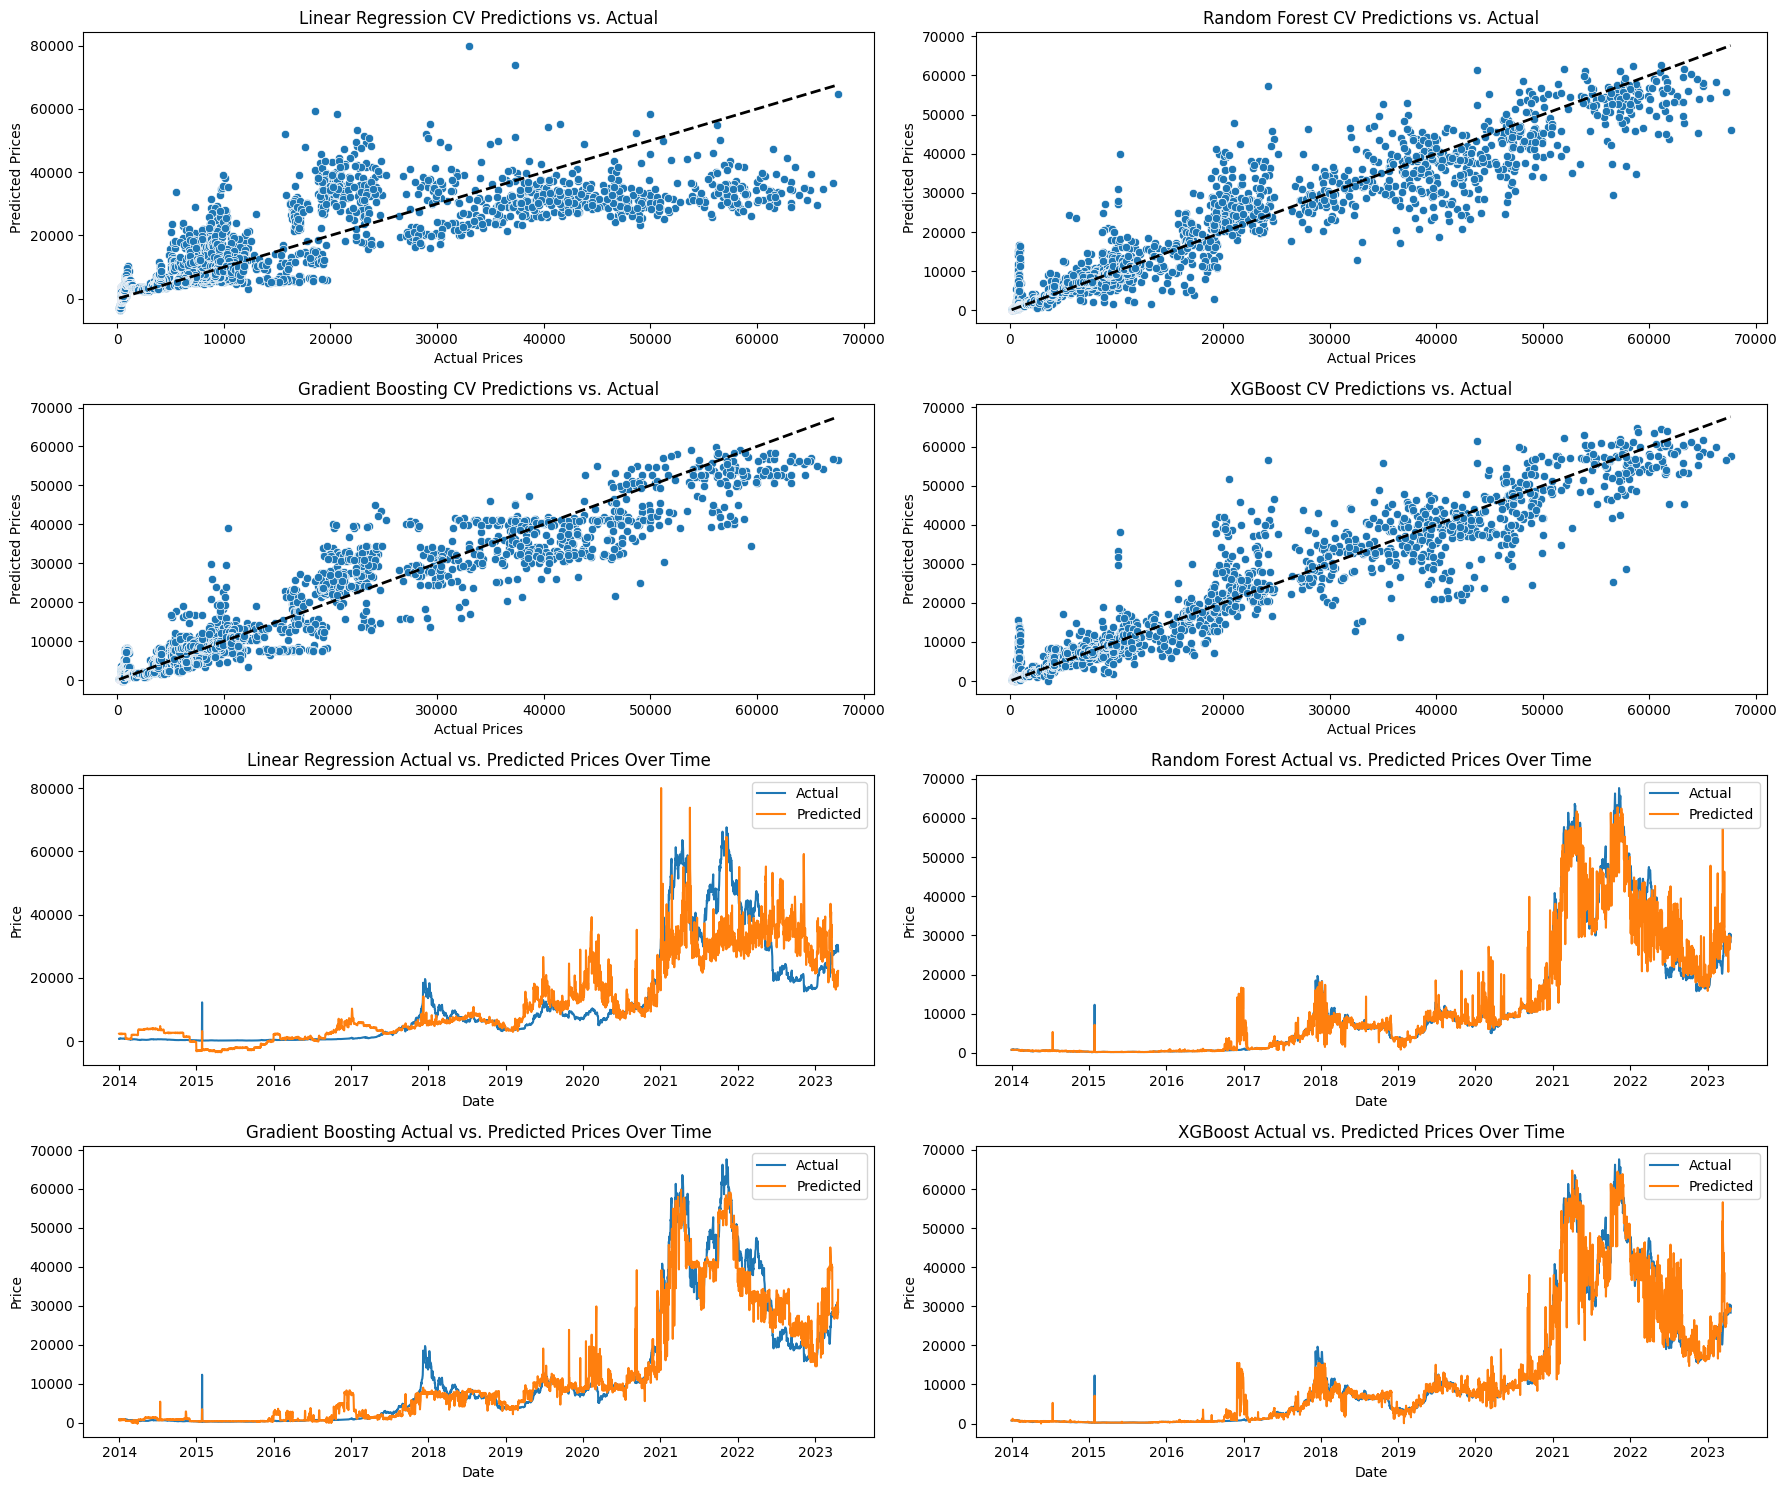

In [19]:

# Visualization of predictions and actual data
plt.figure(figsize=(18, 15))

# Scatter plots for predictions vs. actual prices
plt.subplot(4, 2, 1)
sns.scatterplot(x=y, y=predictions_linear)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Linear Regression CV Predictions vs. Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(4, 2, 2)
sns.scatterplot(x=y, y=predictions_forest)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Random Forest CV Predictions vs. Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(4, 2, 3)
sns.scatterplot(x=y, y=predictions_gb)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Gradient Boosting CV Predictions vs. Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.subplot(4, 2, 4)
sns.scatterplot(x=y, y=predictions_xgb)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('XGBoost CV Predictions vs. Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Graphs for actual vs. predicted prices over time
plt.subplot(4, 2, 5)
plt.plot(merged_data_filled['date'], y, label='Actual')
plt.plot(merged_data_filled['date'], predictions_linear, label='Predicted')
plt.title('Linear Regression Actual vs. Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(merged_data_filled['date'], y, label='Actual')
plt.plot(merged_data_filled['date'], predictions_forest, label='Predicted')
plt.title('Random Forest Actual vs. Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(merged_data_filled['date'], y, label='Actual')
plt.plot(merged_data_filled['date'], predictions_gb, label='Predicted')
plt.title('Gradient Boosting Actual vs. Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(merged_data_filled['date'], y, label='Actual')
plt.plot(merged_data_filled['date'], predictions_xgb, label='Predicted')
plt.title('XGBoost Actual vs. Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


### Visualization of Predictions and Actual Data

This code generates multiple plots to visualize the predictions made by each model compared to the actual prices. It also includes plots showing the actual and predicted prices over time.

#### Scatter Plots for Predictions vs. Actual Prices:
- **Linear Regression CV Predictions vs. Actual:**
  - Scatter plot comparing the actual prices (`y`) with the predicted prices (`predictions_linear`) using Linear Regression.
- **Random Forest CV Predictions vs. Actual:**
  - Scatter plot comparing the actual prices (`y`) with the predicted prices (`predictions_forest`) using Random Forest Regression.
- **Gradient Boosting CV Predictions vs. Actual:**
  - Scatter plot comparing the actual prices (`y`) with the predicted prices (`predictions_gb`) using Gradient Boosting Regression.
- **XGBoost CV Predictions vs. Actual:**
  - Scatter plot comparing the actual prices (`y`) with the predicted prices (`predictions_xgb`) using XGBoost Regression.

#### Graphs for Actual vs. Predicted Prices Over Time:
- **Linear Regression Actual vs. Predicted Prices Over Time:**
  - Line plot showing the actual prices (`y`) and predicted prices (`predictions_linear`) over time.
- **Random Forest Actual vs. Predicted Prices Over Time:**
  - Line plot showing the actual prices (`y`) and predicted prices (`predictions_forest`) over time.
- **Gradient Boosting Actual vs. Predicted Prices Over Time:**
  - Line plot showing the actual prices (`y`) and predicted prices (`predictions_gb`) over time.
- **XGBoost Actual vs. Predicted Prices Over Time:**
  - Line plot showing the actual prices (`y`) and predicted prices (`predictions_xgb`) over time.

### Conclusion:
These visualizations provide insights into how well each model's predictions align with the actual prices and how they evolve over time. It helps in assessing the performance and reliability of each regression model.